In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from scipy.interpolate import interp2d
import six
from stompy import utils
from stompy.grid import unstructured_grid
from stompy.model.suntans import sun_driver

%matplotlib notebook

In [36]:
model=sun_driver.SuntansModel.load("runs/snubby_cfg003_20180317")

INFO:DFlowModel:Will read cell depths, too


In [37]:
map_ds=xr.open_dataset(model.map_outputs()[0])

map_ds['Nkcell']=map_ds['Nk']
del map_ds['Nk']

In [38]:
g=unstructured_grid.UnstructuredGrid.from_ugrid(map_ds)

In [39]:
map_ds_snap=map_ds.isel(time=10)

In [40]:
# depth averaged velocity -- hopefully it's stairstepped.
assert int(model.config['stairstep'])

In [41]:
from stompy.grid import ugrid
import six
six.moves.reload_module(ugrid)
ug=ugrid.UgridXr(map_ds,face_eta_vname='eta')


In [111]:
ug.grid


In [54]:
weights=ug.vertical_averaging_weights(time_slice=10,ztop=0,zbottom=0)
weights=weights.T # to match uc and vc shape

In [52]:
uc3d=map_ds_snap.uc.values
vc3d=map_ds_snap.vc.values


In [73]:
# uc3d.shape ~ Nk, Nc
# in theory, wherever uc/vc is nan, weights would also be zero,
# but roundoff can defeat that, so better to go straight to
# a check on nan
uc2d=np.where(np.isnan(uc3d),0,weights*uc3d).sum(axis=0)
vc2d=np.where(np.isnan(vc3d),0,weights*vc3d).sum(axis=0)


<IPython.core.display.Javascript object>


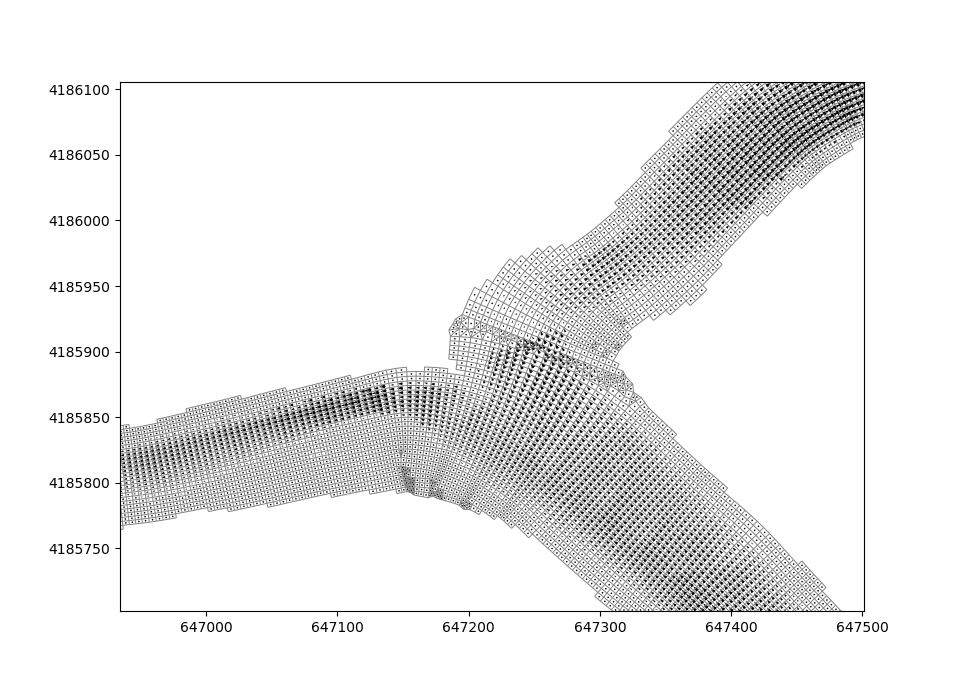

In [76]:
plt.figure()
xy=g.cells_centroid()
g.plot_edges(color='0.5',lw=0.7)
sel=slice(None)
plt.quiver(xy[sel,0], xy[sel,1], uc2d[sel], vc2d[sel], scale_units='xy',angles='xy',scale=0.05)


In [79]:
from scipy.interpolate import LinearNDInterpolator

pnts=np.c_[map_ds.xv.values,map_ds.yv.values]
values=np.c_[uc2d,vc2d]
U=LinearNDInterpolator(pnts, values)


In [102]:
# Vorticity on original centers
eps=0.5 # finite difference length scale

x_samp=g.cells_center()

u0=U(x_samp)
ux=U(x_samp+np.array([eps,0]))
uy=U(x_samp+np.array([0,eps]))

w=(ux[:,1]-u0[:,1])/eps - (uy[:,0]-u0[:,0])/eps
w[np.isnan(w)]=0.0

<IPython.core.display.Javascript object>


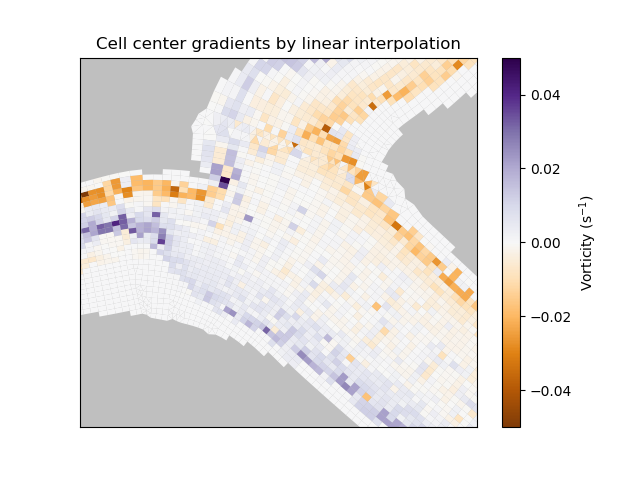

In [108]:
plt.figure()
ax=plt.gca()
ccoll=g.plot_cells(values=w,clim=[-0.05,0.05],cmap='PuOr',ax=ax)
ax.axis('equal')
plt.colorbar(ccoll,label='Vorticity (s$^{-1}$)')
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
ax.set_title('Cell center gradients by linear interpolation')
ax.axis((647111.861966244, 647372.5828754072, 4185718.7656474155, 4185961.614558773))
ax.set_facecolor('0.75')

In [109]:
M=g.smooth_matrix(f=0.5)
wsmooth=w
for _ in range(1):
    wsmooth=M.dot(wsmooth)


<IPython.core.display.Javascript object>


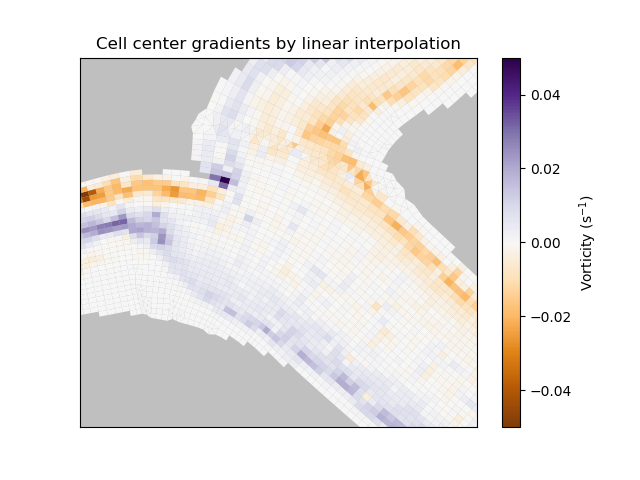

In [110]:
plt.figure()
ax=plt.gca()
ccoll=g.plot_cells(values=wsmooth,clim=[-0.05,0.05],cmap='PuOr',ax=ax)
ax.axis('equal')
plt.colorbar(ccoll,label='Vorticity (s$^{-1}$)')
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
ax.set_title('Cell center gradients by linear interpolation')
ax.axis((647111.861966244, 647372.5828754072, 4185718.7656474155, 4185961.614558773))
ax.set_facecolor('0.75')

Cumulative flow distribution
==

For each location (e.g. segment midpoint), calculate ne flow downstream left of that
location.

May later extend to select a specific elevation (i.e. flow at 1m).

Will also calculate flow to the right, to aid in fractional calculations

<xarray.Dataset>
Dimensions:       (Nc: 9681, Ne: 19684, Nk: 50, Nkw: 51, Np: 10004, Two: 2, numsides: 8, time: 49)
Coordinates:
    xv            (Nc) float64 6.471e+05 6.475e+05 ... 6.475e+05 6.475e+05
    yv            (Nc) float64 4.186e+06 4.186e+06 ... 4.186e+06 4.186e+06
    xe            (Ne) float64 ...
    ye            (Ne) float64 ...
    z_r           (Nk) float64 0.1379 0.4136 0.6893 0.965 ... 13.1 13.37 13.65
    z_w           (Nkw) float64 ...
  * time          (time) datetime64[ns] 2018-03-17 ... 2018-03-18
Dimensions without coordinates: Nc, Ne, Nk, Nkw, Np, Two, numsides
Data variables:
    suntans_mesh  int32 ...
    cells         (Nc, numsides) int32 9756 4432 9647 ... 999999 999999 999999
    nfaces        (Nc) int32 ...
    face          (Nc, numsides) int32 ...
    edges         (Ne, Two) int32 4432 9647 9647 7642 ... 10003 9987 9987 10002
    neigh         (Nc, numsides) int32 ...
    grad          (Ne, Two) int32 ...
    xp            (Np) float64 6.474e+05 6.

In [117]:
inp_fn="../../field/tags/segments_2m.csv"
seg_dnum_to_utc=7./24 # add this to segment dnums to get utc.
segments=pd.read_csv(inp_fn)
# choose the last run of a sequence:
mod=sun_driver.SuntansModel.load('runs/snubby_cfg003_20180411')
seq=mod.chain_restarts()
run_starts=np.array([mod.run_start for mod in seq])
segments['time']=utils.to_dt64(segments.dnm.values+seg_dnum_to_utc)


INFO:DFlowModel:Will read cell depths, too


In [123]:
def map_for_run(run_i):
    outputs=seq[run_i].map_outputs()
    assert len(outputs)==1,"Expecting merged output"
    return xr.open_dataset(outputs[0])

def snap_for_time(run_i,t):
    map_ds=map_for_run(run_i)
    time_idx=utils.nearest(map_ds.time.values, t)
    return map_ds.isel(time=time_idx)

def ug_for_run(run_i):
    # have to give it a bit of help to figure out the eta variable.
    return ugrid.UgridXr(map_for_run(run_i),
                         face_eta_vname='eta')


In [130]:
row=segments.iloc[0]
xy=np.array( [row['xm'],row['ym']])
t=row['time'].to_datetime64()
run_i=np.searchsorted(run_starts,t)-1
time_idx=utils.nearest(ug.nc.time.values, t)
    
snap=snap_for_time(run_i,t)


<IPython.core.display.Javascript object>


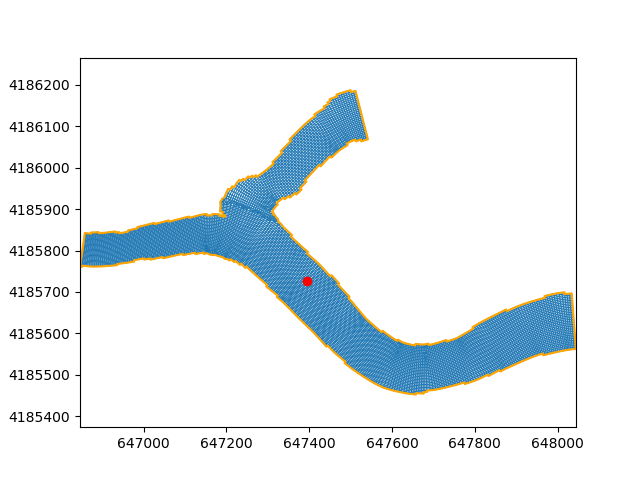

In [134]:
g=unstructured_grid.UnstructuredGrid.from_ugrid(snap)
plt.figure()
g.plot_edges()
plt.plot([xy[0]],[xy[1]],'ro')

In [135]:
# identify nearby points on the 
boundary=g.boundary_polygon()

INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=187833.067312, 0 potential interiors


In [137]:
pnts=np.array(boundary.exterior)
plt.plot(pnts[:,0],pnts[:,1],'-',color='orange')

In [138]:
from stompy.grid import exact_delaunay

In [150]:
dt=exact_delaunay.Triangulation()

for a,b in zip(pnts[:-1,:],pnts[1:,:]):
    na=dt.add_or_find_node(a)
    nb=dt.add_or_find_node(b)
    if na==nb: continue # happens, shouldn't.
    # print(na,a,nb,b)
    dt.add_constraint(na,nb)

In [159]:
gdt.nodes.dtype.names

('x', 'deleted', 'dual_cell')

In [169]:
gdt=dt.create_dual(center='circumenter')


for n in gdt.valid_node_iter():
    if g.select_cells_nearest(gdt.nodes['x'][n],inside=1) is None:
        gdt.delete_node_cascade(n)
        continue
    dc=gdt.nodes['dual_cell'][n]
    if dt.cell_polygon(dc).length < 80:
        gdt.delete_node_cascade(n)
        continue

<IPython.core.display.Javascript object>


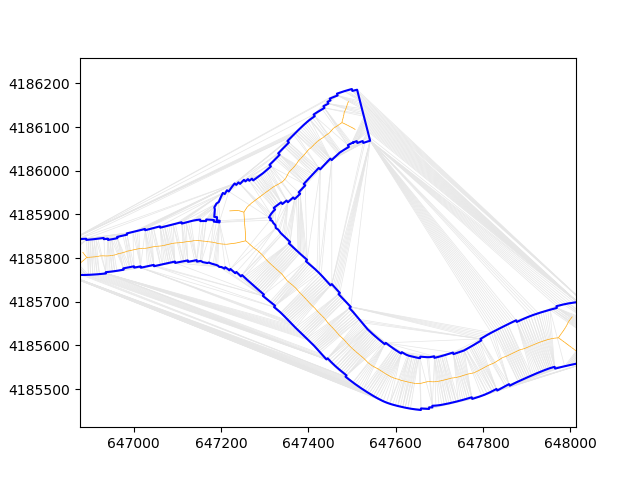

In [170]:

plt.figure()
dt.plot_edges(lw=0.5,color='0.9')
plt.plot(pnts[:,0],pnts[:,1],'b-')
gdt.plot_edges(color='orange',lw=0.5)



In [181]:
# That's a bit much
# try a DT of the dry cells.
e2c=g.edge_to_cells()

shore_edges=[ ]

dry_cells=(snap.eta.values+snap.dv.values)<0.01

for j in g.valid_edge_iter():
    c1,c2=e2c[j]
    dry_left=(c1<0) or dry_cells[c1]
    dry_right=(c2<0) or dry_cells[c2]
    if dry_left != dry_right:
        shore_edges.append(j)

In [193]:
# make that into a polyline
shore_segs=g.nodes['x'][g.edges['nodes'][shore_edges]]
shore_segs.shape
from stompy.spatial import join_features

feats=join_features.merge_lines(segments=shore_segs)
assert len(feats)==1
shore_ring=feats[0]
# code below assumes this is a ring with first vertex repeated
assert np.all(shore_ring[0]==shore_ring[-1])

INFO:join_features:Reading features
INFO:join_features:921 possible matched features
INFO:join_features:merge completed


In [194]:
shore_dists=utils.dist_along(shore_ring)
perim=shore_dists[-1]


<IPython.core.display.Javascript object>


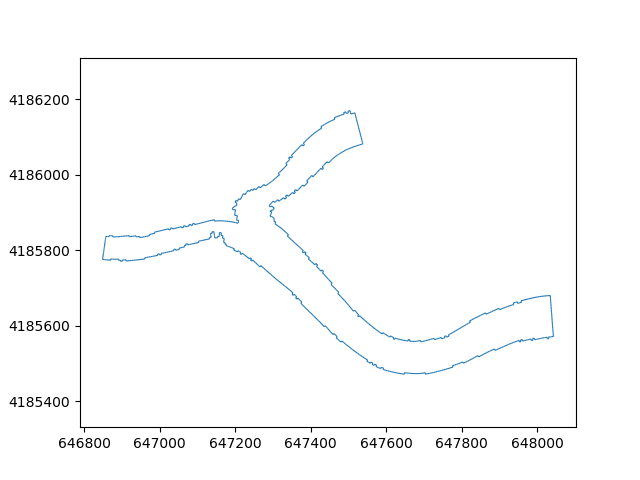

(646789.0484125002, 648103.2102175, 4185436.576665, 4186204.544635)

In [197]:
def pnt_to_span(xy):
    """
    xy: (x,y) coordinate
    returns [2,{x,y}] array
    """
    dists=utils.dist(xy-shore_ring)
    order=np.argsort(dists)
    n1=order[0]
    min_sep=200.0 # the two nodes must be at least this far away
    # from each other along the ring.
    for n2 in order[1:]:
        d1=shore_dists[n1]
        d2=shore_dists[n2]
        sep_f=(d1-d2)%perim # distance forward
        sep_r=perim-sep_f # distance reverse
        sep=min(sep_f,sep_r)
        if sep>min_sep:
            break
    return shore_ring[ [n1,n2],:]

<IPython.core.display.Javascript object>


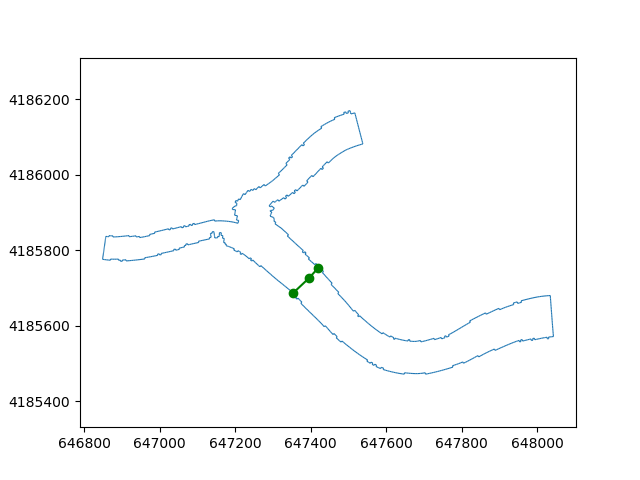

(646789.0484125002, 648103.2102175, 4185436.576665, 4186204.544635)

In [199]:
plt.figure()
g.plot_edges(mask=shore_edges)
span=pnt_to_span(xy)

plt.plot( [span[0,0],xy[0],span[1,0]],
          [span[0,1],xy[1],span[1,1]],'g-o')
plt.axis('equal')
